# MNIST-projekt för kunskapskontroll 2

Jag bygger det här på exemplet i boken, varför gå över ån efter vatten. 
I slutet gör jag en liten extra analys av den valda modellen och ser om det går att bättra på den ytterligare. 


## Importera nödvändiga paket. Skapa funktion för att visa Confusion Matrix.

In [49]:
# Paket för data och modellering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

# Funktionsdefinition
def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    
# För export av modellen för vidare användning i Streamlit-appen
from joblib import dump

Läs in data och ta en titt.

In [17]:
# Läs in hela MNIST
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X = mnist["data"]              
y = mnist["target"].astype(np.uint8)




(70000, 784)
(70000,)
True label for the plotted image is  5


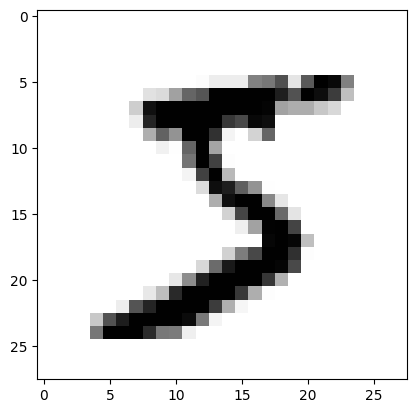

In [18]:
# Kolla på grejerna
print(X.shape)
print(y.shape)

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
print("True label for the plotted image is ", y[0])

# print(mnist.DESCR)
# jag kopierade in detta i en markdown för bättre läsbarhet.

Här är det lite intressant att siffrorna i MNIST är vita mot svart bakgrund, men med koden från boken visas de som ovan. Det var inte bara irriterande, det var också dåligt eftersom jag hade fullt sjå att få prediktionen rätt. 

The MNIST database of handwritten digits with 784 features, raw data available at:
http://yann.lecun.com/exdb/mnist/

It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples.

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

The original black and white (bilevel) images from NIST were size normalized to fit in a 20×20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. The images were centered in a 28×28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28×28 field.

With some classification methods (particularly template-based methods, such as SVM and K-nearest neighbors), the error rate improves when the digits are centered by bounding box rather than center of mass. If you do this kind of pre-processing, you should report it in your publications.

The MNIST database was constructed from NIST's. NIST originally designated SD-3 as their training set and SD-1 as their test set. However, SD-3 is much cleaner and easier to recognize than SD-1. The reason for this can be found in the fact that SD-3 was collected among Census Bureau employees, while SD-1 was collected among high-school students.

Drawing sensible conclusions from learning experiments requires that the result be independent of the choice of training set and test set among the complete set of samples. Therefore it was necessary to build a new database by mixing NIST's datasets.

The MNIST training set is composed of 30,000 patterns from SD-3 and 30,000 patterns from SD-1. The test set was composed of 5,000 patterns from SD-3 and 5,000 patterns from SD-1. The 60,000-pattern training set contained examples from approximately 250 writers. The sets of writers of the training set and test set were made disjoint.

SD-1 contains 58,527 digit images written by 500 different writers. In contrast to SD-3, where blocks of data from each writer appeared in sequence, the data in SD-1 is scrambled. Writer identities for SD-1 are available and were used to unscramble the writers.

SD-1 was then split in two: characters written by the first 250 writers went into the new training set. The remaining 250 writers were placed in the new test set. Thus there were two sets with nearly 30,000 examples each.

The new training set was completed with enough examples from SD-3, starting at pattern #0, to make a full set of 60,000 training patterns. Similarly, the new test set was completed with SD-3 examples starting at pattern #35,000 to make a full set with 60,000 test patterns. Only a subset of 10,000 test images (5,000 from SD-1 and 5,000 from SD-3) is available on this site. The full 60,000-sample training set is available.

Downloaded from openml.org.

## Splitting time!
Eftersom jag nu är äldre och visare än när jag lämnade in förra uppgiften så börjar jag direkt att dela upp data.  

In [19]:
# Dela först upp så att jag får 10000 testrader
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, 
    test_size=10000, 
    random_state=42
)

# Ta sedan ut 10000 valideringsrader
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=10000, 
    random_state=42
)


Vi skalar data. 

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Testar att träna tre modeller och kombinera i en voting classifier. 

In [21]:
logreg_clf = LogisticRegression(max_iter=1000)
random_forest_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)
extra_trees_clf = ExtraTreesClassifier(
    n_estimators=100,
    random_state=42
)

named_estimators = [
    ("logreg_clf", logreg_clf),
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
]

voting_clf = VotingClassifier(named_estimators, voting="hard")

models = [logreg_clf, random_forest_clf, extra_trees_clf, voting_clf]
for model in models:
    model.fit(X_train, y_train)

print("Accuracy for each model")
model_names = ["Logistic Regression", "Random Forest", "Extra Trees", "Voting Classifier"]
for name, model in zip(model_names, models):
    score = model.score(X_val, y_val)
    print(f"{name:20s}: {score:.4f}")

Accuracy for each model
Logistic Regression : 0.9110
Random Forest       : 0.9692
Extra Trees         : 0.9715
Voting Classifier   : 0.9696


Extra Trees är bäst (bättre än voting?!?) så vi tar en titt på den.

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       997
           1       0.99      0.98      0.99      1158
           2       0.96      0.97      0.97      1007
           3       0.97      0.96      0.96      1028
           4       0.97      0.97      0.97       966
           5       0.96      0.97      0.96       885
           6       0.98      0.99      0.98       945
           7       0.97      0.97      0.97      1070
           8       0.97      0.96      0.97       988
           9       0.95      0.96      0.96       956

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



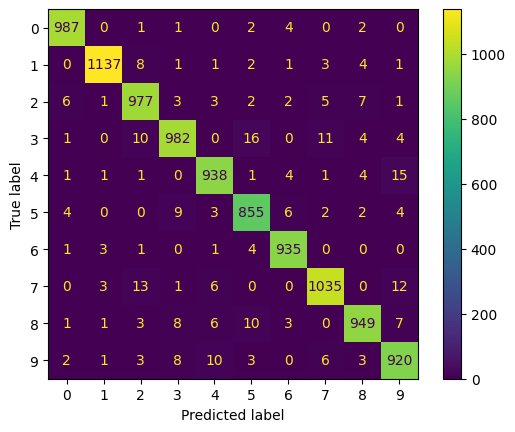

In [22]:
et_pred_val = extra_trees_clf.predict(X_val)

display_confusion_matrix(y_val, et_pred_val)
print(classification_report(y_val, et_pred_val))


Innan vi nöjer oss ska vi försöka fila på hyperparametrarna. Det var lite meckigt och jag fick prova fram och tillbaka med ganska många olika kombinationer. Koden nedan är en "ögonblicksbild", men det har gjorts en hel del ändringar fram och tillbaka. 

In [26]:
# Först och främst tränar vi om modellen för att ha en bra 
# baseline med de inställningar som gav bra resultat ovan.
m_orig = ExtraTreesClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
m_orig.fit(X_train, y_train)
acc_orig = m_orig.score(X_test, y_test)
print("Original 100 träd:", acc_orig)


Original 100 träd: 0.9691


In [27]:
# Så kör vi lite GridSearch för att jämföra
m_grid = ExtraTreesClassifier(
    n_estimators=200,
    max_depth=None,
    max_features="sqrt",
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
m_grid.fit(X_train, y_train)
acc_grid = m_grid.score(X_test, y_test)
print("GridSearch 200 träd:", acc_grid)


GridSearch 200 träd: 0.9702


In [ ]:
# Vi chansar på ytterligare 100 träd. 
m_grid = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=None,
    max_features="sqrt",
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
m_grid.fit(X_train, y_train)
acc_grid = m_grid.score(X_test, y_test)
print("GridSearch 300 träd:", acc_grid)


GridSearch 200 träd: 0.9701


In [ ]:
# Vi kör lite test på olika antal träd. 
n_list = [100, 150, 200, 250, 300]

results = {}

for n in n_list:
    clf = ExtraTreesClassifier(
        n_estimators=n,
        max_depth=None,          
        max_features="sqrt",     
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print(f"n_estimators={n}: test accuracy = {acc:.4f}")
    results[n] = (clf, acc)

n_estimators=100: test accuracy = 0.9691
n_estimators=150: test accuracy = 0.9700
n_estimators=200: test accuracy = 0.9702
n_estimators=250: test accuracy = 0.9708
n_estimators=300: test accuracy = 0.9701


In [ ]:
# Efter omfattande körning med olika alternativ visar det sig att estimators ska vara 250, ingen max depth och max_features sqrt. samt min_samples_split = 2 och leaf = 1
extra_trees_clf = ExtraTreesClassifier(
    n_estimators=250,
    random_state=42,
    n_jobs=-1
)

extra_trees_clf.fit(X_train, y_train)

y_pred = extra_trees_clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy Extra Trees (final): {test_acc:.4f}")


Test accuracy ExtraTrees (final): 0.9708


Innan vi väljer Extra Trees vill jag snegla på SVM. Vi kör en liten test. 

In [53]:
from sklearn.svm import SVC

# Vi kör ett urval så att det går snabbare
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train, y_train,
    # train_size=10000,      # t.ex. 10 000 träningsbilder
    stratify=y_train,
    random_state=42
)

svm_clf = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    random_state=42
)

svm_clf.fit(X_train_sub, y_train_sub)

y_pred = svm_clf.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred)
print(f"SVM (RBF) test accuracy: {svm_acc:.4f}")


SVM (RBF) test accuracy: 0.9583


In [50]:
# Vi testar lite olika gamma
for g in [0.001, 0.0001]:
    svm_clf = SVC(
        kernel="rbf",
        C=10.0,          
        gamma=g
    )
    svm_clf.fit(X_train_sub, y_train_sub)
    y_pred = svm_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"gamma={g}: test accuracy = {acc:.4f}")

gamma=0.001: test accuracy = 0.9466
gamma=0.0001: test accuracy = 0.9306


# Stopp och belägg!

Nej, efter en massa experiment så verkar det inte som att det är lönt att kludda mer. Jag gör helt sonika ett val och bestämmer mig för Extra Trees. 

Jag tränar om modellen på både tränings- och valideringsdata.

In [45]:
X_train_val = scaler.fit_transform(X_train_val)
extra_trees_clf.fit(X_train_val, y_train_val)

#Utvärdera på testdata
et_pred_test = extra_trees_clf.predict(X_test)

print(classification_report(y_test, et_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       0.99      0.99      0.99      1152
           2       0.95      0.97      0.96       967
           3       0.96      0.96      0.96      1034
           4       0.97      0.98      0.97       906
           5       0.98      0.96      0.97       937
           6       0.98      0.99      0.98       961
           7       0.97      0.97      0.97      1055
           8       0.96      0.95      0.96       969
           9       0.96      0.96      0.96      1036

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Modellen ger värden som är "good enough". Eftersom neurala nätverk inte fick användas så får det duga. Vi tränar om den på hela datasetet

In [46]:
scaler_2 = StandardScaler()
X = scaler_2.fit_transform(X)
extra_trees_clf.fit(X, y)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",250
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=FalseWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",False
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metr

Visualisering i en fin heatmap

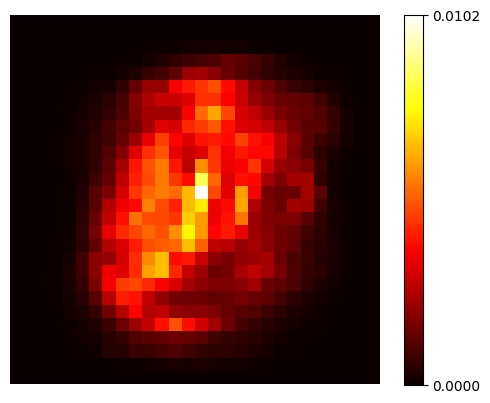

In [47]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap=mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

plot_digit(extra_trees_clf.feature_importances_)

cbar = plt.colorbar(ticks=[extra_trees_clf.feature_importances_.min(), extra_trees_clf.feature_importances_.max()])

# Slutsats

Efter genomgång av de här modellerna har det visat sig att Extra Trees är den bästa modellen (bäst accuracy). Jag väljer därför att använda den för appen.

Jag skulle teoretiskt sett kunnat göra en separat .py-fil för den här modellen, men som sagt - varför gå över ån efter vatten. Vi dumpar ned modellen via joblib. 

In [ ]:
dump(extra_trees_clf, "mnist_extratrees_final.joblib")


['mnist_extratrees_final.joblib']

In [52]:
dump(scaler, 'mnist_scaler.joblib')

['mnist_scaler.joblib']